# **Image Transformation**

This book will explore using `OpenCV` to transform a front-view image taken from a vehicle into a bird-eye view of the lane ahead.

## **Imports**

In [1]:
import cv2
import matplotlib.pyplot as plt
import numpy as np

from src.utility import *

## **Motivation**

Imagine standing in the middle of a long stretch of road. The is a solid lane marker to your left and right that extends the entire length of the road. As you focus on the middle portion of the road, you'll see that the lane lines look almost like they are converging though you know they run parallel. We can see the same phenomenon with pictures taken from cameras. For example, let's take a look at a test image. Pay attention to how the lane lines seem to converge the further out they go.

<div>
<img src="test_images/straight_lines1.jpg" width="1000"/>
</div>

The point in the horizon that the lines seem to converge to is known as the vanishing point and the reason as to why they seem to converge has to do with diminution. That is the further out we look, the smaller the objects look resulting in a converging perspective. 

This is great and all, but what does it have to do with our computer vision application? Well we inherently know that though they may look it, the lines do not converge. Though we may be able to detect lines from this perspective, if we want to include any measurements (distance, radius, etc.) the results will not be as precise as having a top-down image. This image transformation becomes much more useful as the the degree of complexity increases. If we wanted to do path planning or lane centering, it is intuitively easier to plan a trajectory with a top-down view instead of from the front. The angle and position of the camera can vary from car to car as well and if we can reliably transform the image to top-down, the issues from the varying perspectives disappear. In any case, the flatter the image of the road is, the better we can estimate.

## **Region of Interest**

Before we start with the transformation though, we need to define what region of this image is important to us. The lane detection algorithm relies on the colour (and to a degree contrast) difference between the lane markers and the road surface. The front view contains a myriad of colours and details, most of which are of no interest to us. The sky is not relevant, neither is anything outside of the vehicle's lane boundaries (for our application). The only region in the image that is important to us is the lane ahead of the vehicle and we can define this region as the **region of interest (ROI)**. Let's look at our image and define a set of points that contains our ROI.

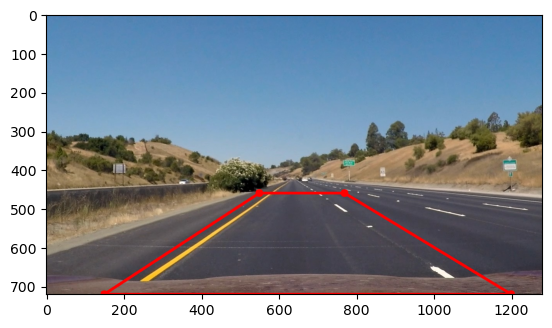

In [9]:
# Load in image and convert to RGB
orig_img = cv2.imread('test_images/straight_lines1.jpg')
img = cv2.cvtColor(orig_img, cv2.COLOR_BGR2RGB)

# Define the ROI vertices as coordinates (x, y)
roi_points = np.int32([[
    (550, 460),
    (150, 720),
    (1200, 720),
    (770, 460)
]])

# Call the function to draw the ROI on the image
img = draw_roi(img, roi_points, (255, 0, 0))

plt.imshow(img)

The width and depth of the ROI doesn't matter too much in this case. We just want to make sure that we encapsulate the lane markers and give ourselves enough of a buffer to work with, without introducing excess noise. Once or twice I had to tweak the ROI points when the lane detection algorithm wasn't working. Sometimes there would be large gaps where lane markers didn't exist, or there wasn't enough contrast between the road and the markings where the asphalt was lighter. Increasing the depth helped remedy that as it allowed more lane markers to enter the ROI at the expense of added noise. Also in cases of unfavorable road surface conditions and curves, a narrow ROI might not capture the curvature of the road. Two wide and you have the chance of adding noise in the form of foreign objects on the shoulder or other vehicles in the other lanes. The best ROI is picked where you can get the most lane marker information without excess noise.

## **Bird's Eye View**

Now that we have our ROI, we can use `OpenCV` to perform an [image transform](https://docs.opencv.org/4.x/da/d54/group__imgproc__transform.html). Without explaining the math behind it, the idea is to create source points (our ROI points) from the original image and destination points which define the top-down image vertices. Finding the destination points ins not an easy task. In some cases there can be a strategy behind it, in other cases it's just trial and error. This is an important step as it defines the quality of the image that will be used to detect the lane lines. These points make up our transformation matrix which will be used to transform the perspective of all of our images.

In [10]:
# Reshaping ROI points to work with OpenCV
src_points = np.float32(roi_points.reshape(-1, 2))

# Destination points
dst_points = np.float32([
    (100, 0),
    (100, 750),
    (1100, 750),
    (1100, 0)
])

# Get transformation matrix
matrix = cv2.getPerspectiveTransform(src_points, dst_points)

OpenCV makes it simple to apply the transformation with a single function call using the previously found matrix.

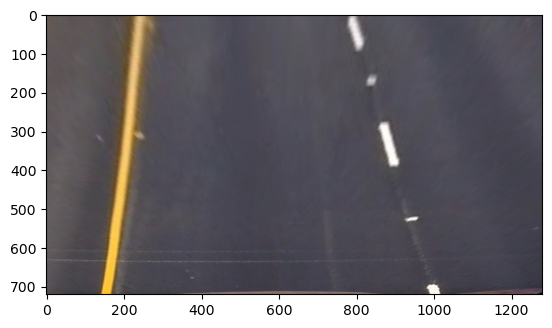

In [11]:
# Transform from front-view to top-view
result = cv2.warpPerspective(orig_img, matrix, (orig_img.shape[1], orig_img.shape[0]))
result = cv2.cvtColor(result, cv2.COLOR_BGR2RGB)

plt.imshow(result)

Great! We have the top-down (I sometimes refer to this as bird's-eye-view) of the lane ahead of us. You might notice that we still have perspective distortion where the lines appear to be converging the further they get. If you play around with the transformation enough, you'll end up with a better perspective that has less distortion, though it likely won't be perfect. Now that we transformed the perspective, the next step is to threshold the image to separate the lane markers from the road.

## **Thresholding**

Though we have the bird's eye view of the road ahead, we still need to do a bit more image processing before curve detection. Right now our image is coloured which makes it difficult to separate the features we are interested in from the background. It would be better to work with a binary image where the background is black and the lane lines are white. Instead of using a RGB image, we can explore using `HLS` (hue, lightness, saturation) or `HSV` (hue, saturation, value) colour spaces. Let's see what each one actually represents.

### **HLS**

1) **Hue**

    The hue channel represents the colours in the image as an angle of the standardized colour wheel. Where 0/360 is red, 120 is green, and 240 is blue.

2) **Lightness**

    The lightness channel represents the overall brightness of the image from black (0) to white (1). In essence, this channel describes the shadows and highlights of an image.

3) **Saturation**

    The saturation channel represents the purity of the colors in the image. It ranges from a middle-grey (0) to the purist possibility (1). This channel is useful for image segmentation based on objects that are highly vivid and/or dull.

### **HSV**

1) **Hue**

    This channel is the exact same for both colour spaces.

2) **Saturation**

    Similar to HSL, the saturation channel describes the purity of the colours. However, the values range from white (0%) to the purist possibility (100%) instead.

3) **Value**

    The value channel describes the brightness of the colours ranging from the darkest (0%) and purist (100%) values of the colours.

From reading this you might feel like the two colour spaces are similar, however there are some intricate differences in how each space can be used. You can explore this topic more in this well-structured [article](https://www.tobiamontanari.com/hsl-and-hsv-explained-which-color-model-should-you-use/). Let's take a look at each channel from both color spaces using our bird's-eye view image.

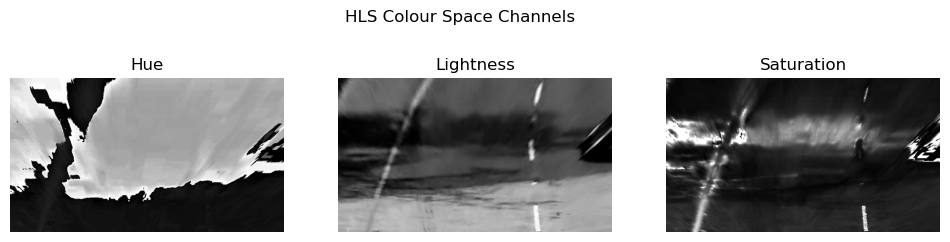

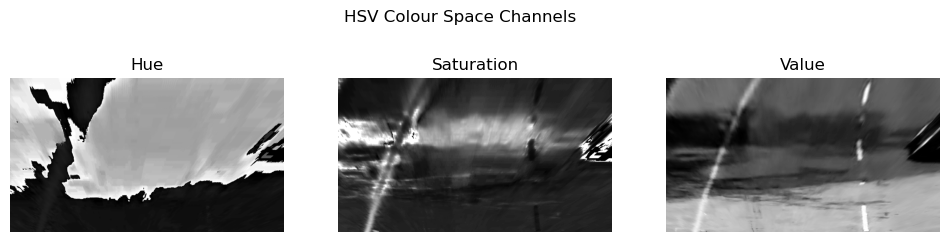

In [5]:
hls = cv2.cvtColor(result, cv2.COLOR_RGB2HLS)
hsv = cv2.cvtColor(result, cv2.COLOR_RGB2HSV)

hls_dict = {
    'Hue' : hls[:,:,0],
    'Lightness' : hls[:,:,1],
    'Saturation' : hls[:,:,2]
}

hsv_dict = {
    'Hue' : hsv[:,:,0],
    'Saturation' : hsv[:,:,1],
    'Value' : hsv[:,:,2]
}

plot_channels(hls_dict, title='HLS Colour Space Channels')
plot_channels(hsv_dict, title='HSV Colour Space Channels')

From the outputs above it seems like both the `Value` channel from the `HSV` colour space and the `Lightness` channel from `HLS` are doing a good job at separating the lane lines from the road. Though the outputs are similar, the biggest difference is tha the left solid line is more intense in the Value channel as compared to the Light channel. Remember that the Value channel looks at the brightness of the colours from dark to the **purest** value and the lightness channel looks at the brightness from dark to **white**. Meaning that if we are going to have coloured lines (and markings) on the road, it would be better to go with the Value channel.

### **Binary Thresholding**

We now have an image that gives us a good foundation to move forward. The next step is to take this image and transform it into a binary representation where the pixel we keep are determined using a threshold range. Note that we want to keep only the brightest pixels and that the Value channels pixel intensities range from 0 (least-intense) to 255 (most-intense). Knowing this we can specify a range of intensities from which only the pixels in that range will be kept. Let's try out a range of 200 to 255.

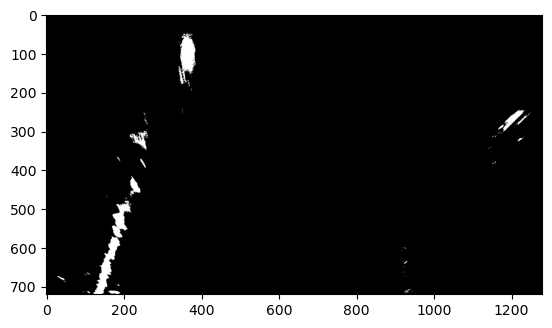

In [6]:
test = np.zeros_like(hsv[:,:,0])
test[(hsv[:,:,0] >= 20) & (hsv[:,:,0] <= 30)] = 1
plt.imshow(test, cmap='gray')

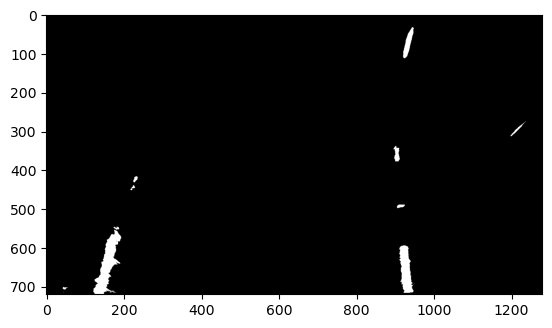

In [7]:
v_channel = hsv_dict['Value']
thresh = (210, 255)

output = np.zeros_like(v_channel)
output[(v_channel >= thresh[0]) & (v_channel <= thresh[1])] = 1

plt.imshow(output, cmap='gray')
plt.imsave('book_images/threshold.png', output, cmap='gray')

Great! Now we have a binary image showing only the lane markers. The next step is to fit a polyline for the left and right lane lines.